<a href="https://colab.research.google.com/github/Dvarkesh12/Demo_merge/blob/main/Blockage_Detection_Recent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

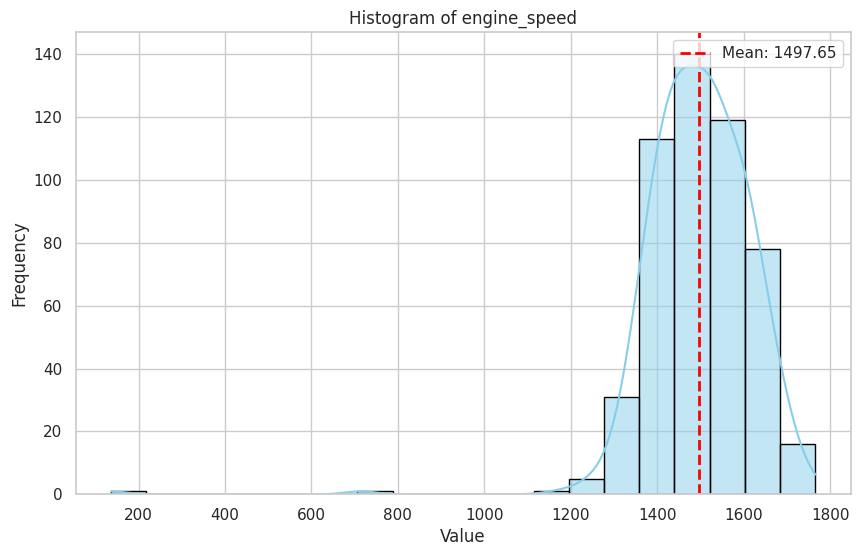

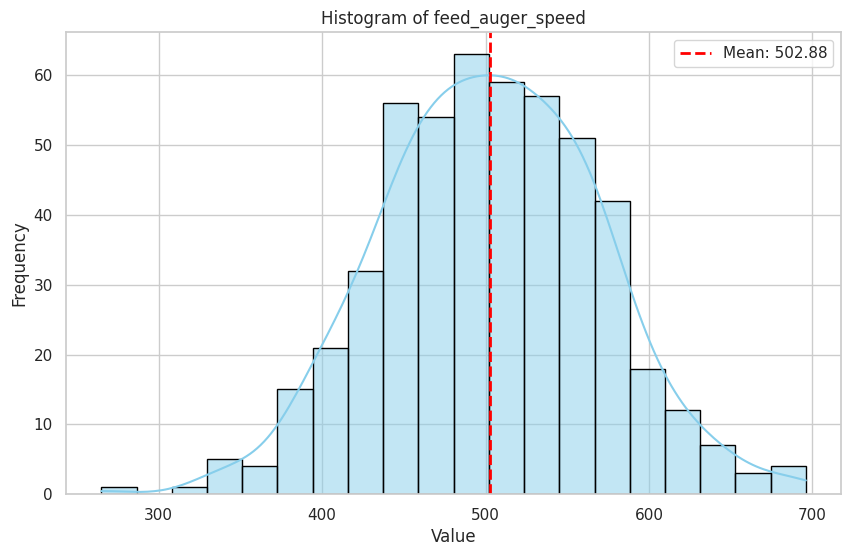

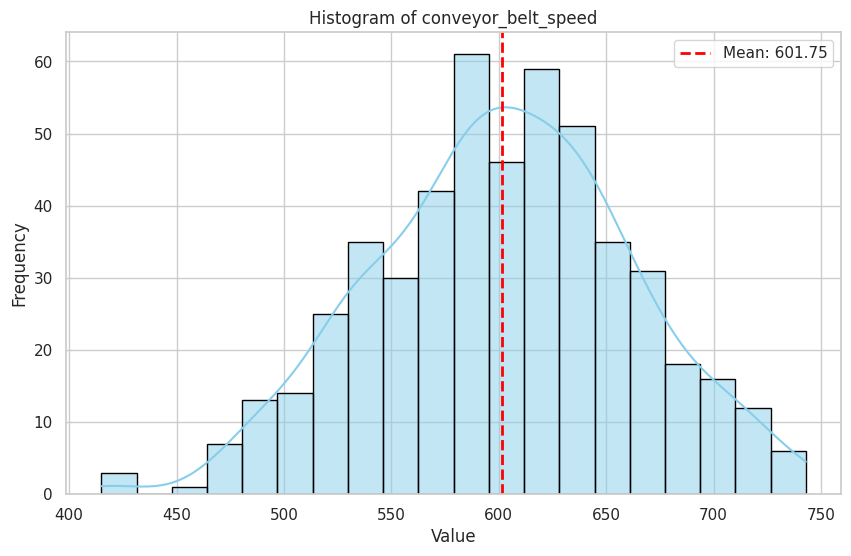

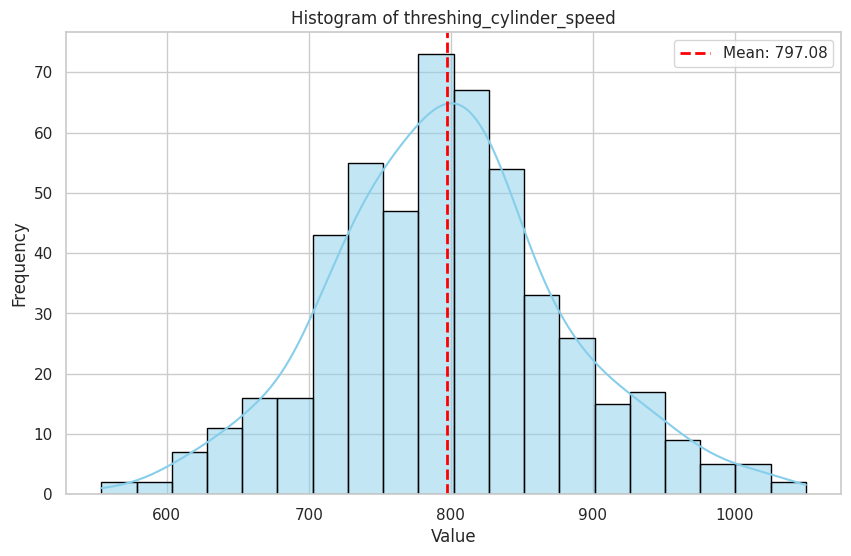

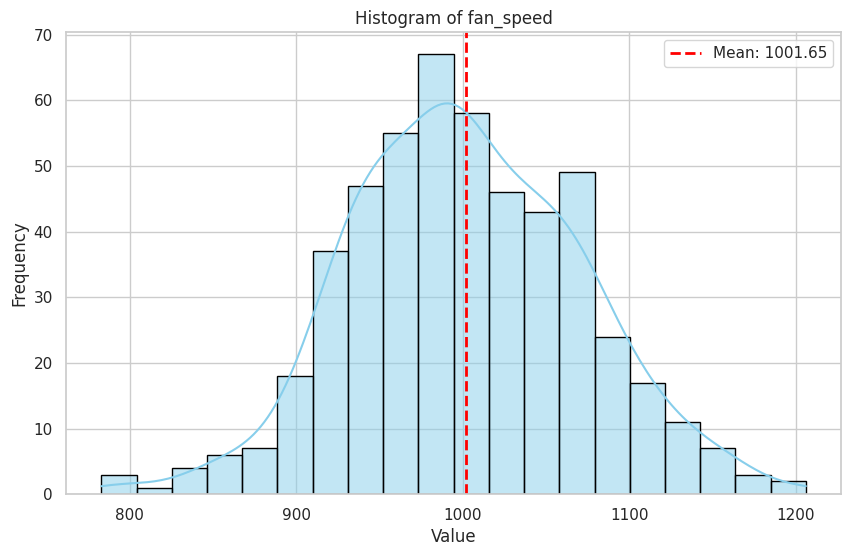

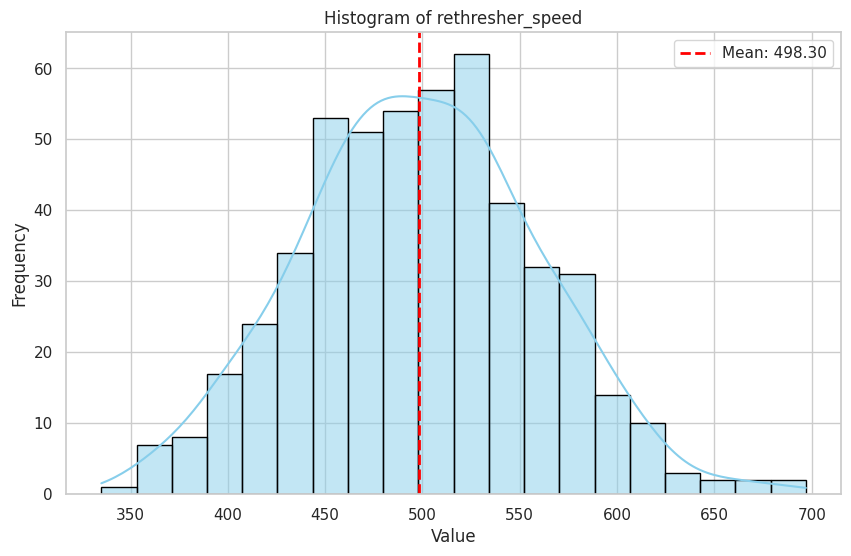

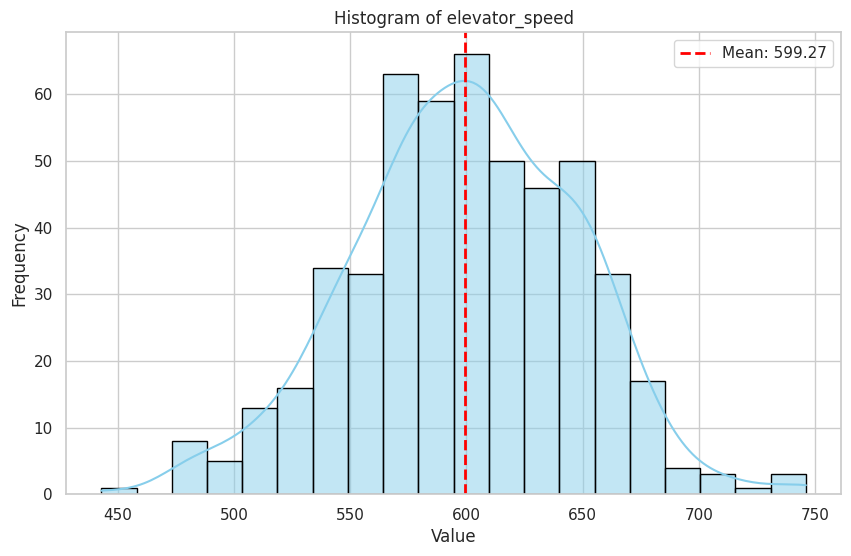

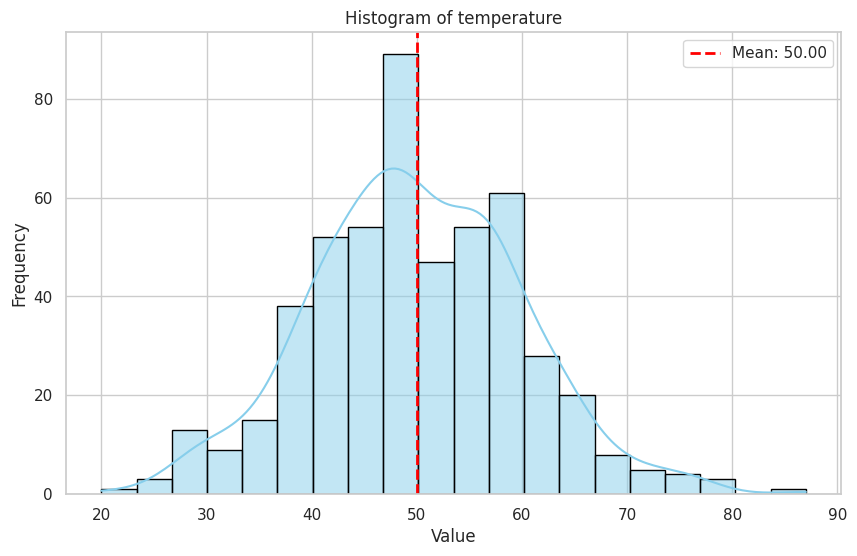

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

## Write down all input here
# Number of samples
num_samples = 505
T_max = 500
# Define weights and maximum values for normalization
W1, W2, W3, W4 = 0.4, 0.3, 0.2, 0.1  # Example weights


# Average speeds in normal conditions
average_speeds = {
    'engine_speed': 1500,
    'feed_auger_speed': 500,
    'conveyor_belt_speed': 600,
    'threshing_cylinder_speed': 800,
    'fan_speed': 1000,
    'rethresher_speed': 500,
    'elevator_speed': 600,
    'temperature': 50
}

# Standard deviations for the speeds
std_devs = {
    'engine_speed': 100,
    'feed_auger_speed': 70,
    'conveyor_belt_speed': 60,
    'threshing_cylinder_speed': 80,
    'fan_speed': 70,
    'rethresher_speed': 60,
    'elevator_speed': 50,
    'temperature': 10
}

# Generate normally distributed data for each speed parameter
data = {key: np.round(np.random.normal(average_speeds[key], std_devs[key], num_samples)) for key in average_speeds}

# Create a DataFrame
df = pd.DataFrame(data)

# # Introduce outliers for various speed parameters
# num_outliers = num_samples

# outlier_indices_1 = np.random.choice(num_samples, num_outliers, replace=True)
# ##################### INPUT ###################
# A = 1500  # Starting value
# k = 0.005  # Decay rate, adjust this to control how quickly the values decrease

# df.loc[outlier_indices_1, 'engine_speed'] = A * np.exp(-k * np.arange(num_samples))

num_outliers = 2
outlier_indices_1 = np.random.choice(num_samples, num_outliers, replace=True)
df.loc[outlier_indices_1, 'engine_speed'] =  np.round(np.random.uniform(0, 1100, num_outliers))

# outlier_indices_2 = np.random.choice(num_samples, num_outliers, replace=True)
# df.loc[outlier_indices_2, 'feed_auger_speed'] = np.round(np.random.uniform(0, 360, num_outliers))

# outlier_indices_3 = np.random.choice(num_samples, num_outliers, replace=True)
# df.loc[outlier_indices_3, 'conveyor_belt_speed'] = np.round(np.random.uniform(0, 420, num_outliers))

# outlier_indices_4 = np.random.choice(num_samples, num_outliers, replace=True)
# df.loc[outlier_indices_4, 'threshing_cylinder_speed'] = np.round(np.random.uniform(0, 560, num_outliers))

# outlier_indices_5 = np.random.choice(num_samples, num_outliers, replace=True)
# df.loc[outlier_indices_5, 'fan_speed'] = np.round(np.random.uniform(10, 790, num_outliers))

# outlier_indices_6 = np.random.choice(num_samples, num_outliers, replace=True)
# df.loc[outlier_indices_6, 'rethresher_speed'] = np.round(np.random.uniform(0, 320, num_outliers))

# outlier_indices_7 = np.random.choice(num_samples, num_outliers, replace=True)
# df.loc[outlier_indices_7, 'elevator_speed'] = np.round(np.random.uniform(0, 450, num_outliers))

# outlier_indices_8 = np.random.choice(num_samples, num_outliers, replace=True)
# df.loc[outlier_indices_8, 'temperature'] = np.round(np.random.uniform(80, 100, num_outliers))  # Temperature outliers

# Save the generated data to an Excel file
df.to_excel('combine_harvester_dummy_data_rounded.xlsx', index=False)


## All speed parameters and tempreture
speed_columns = [
    'main_clutch_speed', 'feed_auger_speed', 'conveyor_chain_harrow_speed',
    'threshing_cylinder_speed', 'fan_speed', 'rethresher_speed', 'elevator_speed', 'temperature'
]

def plot_histograms(df, speed_columns):
    for column in speed_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[column], bins=20, kde=True, color='skyblue', edgecolor='black')
        plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df[column].mean():.2f}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {column}')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

plot_histograms(df, average_speeds.keys())

In [ ]:
# Function to calculate the first-order difference
def first_order_difference(data):
    return np.diff(data, prepend=data[0])

# Function to calculate the second-order difference
def second_order_difference(data):
    first_order_diff = first_order_difference(data)
    return np.diff(first_order_diff, prepend=first_order_diff[0])

# Function to calculate the differential cumulative sum
def differential_cumulative_sum(speed_data):
    delta_speed_data = first_order_difference(speed_data)
    cum_sum_speed_data = np.cumsum(delta_speed_data)
    return cum_sum_speed_data

# Function to calculate the relative speed ratio
def calculate_relative_speed_ratio(speed_data, max_speed):
    return np.round((speed_data / max_speed) * 100,2)

# Function to calculate the Speed Fusion Index for a given speed parameter
def calculate_speed_fusion_index(speed_parameter, W1, W2, W3, W4, Amax, Cmax, Bmax, A2max):
    speed_data = df[speed_parameter]

    delta_speed_parameter = first_order_difference(speed_data)
    cumulative_delta_speed_parameter = differential_cumulative_sum(speed_data)
    relative_speed_ratios = calculate_relative_speed_ratio(speed_data, average_speeds[speed_parameter])
    second_order_speed_parameter = second_order_difference(speed_data)

    # Calculate Speed Fusion Index E
    E = (
        W1 * delta_speed_parameter / Amax +
        W2 * relative_speed_ratios / Cmax +
        W3 * cumulative_delta_speed_parameter / Bmax +
        W4 * second_order_speed_parameter / A2max
    )

    return delta_speed_parameter, cumulative_delta_speed_parameter, relative_speed_ratios, second_order_speed_parameter, np.round(E,2)



# Calculate max values for each speed parameter
max_values = {}
for parameter in average_speeds.keys():
    if parameter != 'temperature':  # Skip temperature as it's not a speed parameter

        delta_A = first_order_difference(df[parameter])
        cumulative_delta_A = differential_cumulative_sum(df[parameter])
        relative_speed_ratio = calculate_relative_speed_ratio(df[parameter], average_speeds[parameter])
        second_order_A = second_order_difference(df[parameter])

        # Store max values for normalization
        max_values[parameter] = {
            'Amax': np.max(delta_A),
            'Cmax': np.max(relative_speed_ratio),
            'Bmax': np.max(cumulative_delta_A),
            'A2max': np.max(second_order_A)
        }

        delta_speed, cumulative_delta, relative_speed, second_order, E = calculate_speed_fusion_index(
            parameter,
            W1, W2, W3, W4,
            max_values[parameter]['Amax'],
            max_values[parameter]['Cmax'],
            max_values[parameter]['Bmax'],
            max_values[parameter]['A2max']
        )

        result_df = pd.DataFrame({
            'speed_parameter': df[parameter],
            'first_order_difference': delta_speed,
            'second_order_difference': second_order,
            'relative_speed_ratio': relative_speed,
            'speed_fusion_index': E
        })

        result_df.to_excel(f'{parameter}_results.xlsx', index=False)

print("Excel files created for each speed parameter.")

def adaptive_fusion_threshold(speed_data, parameter_name):
    mean_value = np.mean(speed_data)
    std_dev = np.std(speed_data)

    positive_threshold = round(mean_value + 3 * std_dev,2)
    negative_threshold = round(mean_value - 3 * std_dev,2)

    print(f"{parameter_name} -> Positive Threshold: {positive_threshold}, Negative Threshold: {negative_threshold}")

    return positive_threshold, negative_threshold


# Process of the fault diagnosis algorithm
def fault_diagnosis_algorithm(df):
    # Check temperature
    if np.any(df['temperature'] > T_max):
        return "Alarm: Over Temperature"


    # Calculate first-order differences for each speed parameter
    delta_engine_speed = first_order_difference(df['engine_speed'])
    delta_feed_auger_speed = first_order_difference(df['feed_auger_speed'])
    delta_threshing_cylinder_speed = first_order_difference(df['threshing_cylinder_speed'])
    delta_fan_speed = first_order_difference(df['fan_speed'])
    delta_rethresher_speed = first_order_difference(df['rethresher_speed'])
    delta_elevator_speed = first_order_difference(df['elevator_speed'])
    delta_conveyor_belt_speed = first_order_difference(df['conveyor_belt_speed'])

    # Check if all of the first-order differences are negative
    all_delta_negative = (
        np.all(delta_engine_speed < 0) or
        np.all(delta_feed_auger_speed < 0) or
        np.all(delta_threshing_cylinder_speed < 0) or
        np.all(delta_fan_speed < 0) or
        np.all(delta_rethresher_speed < 0) or
        np.all(delta_elevator_speed < 0) or
        np.all(delta_conveyor_belt_speed < 0)
    )



    # if  all_delta_negative:
    #     print("Initial Suspected Condition")


    # Loop through each parameter and check if any speed fusion index is outside the permissible limit
    for parameter in average_speeds.keys():
        if parameter != 'temperature':
            results_data = f'{parameter}_results.xlsx'
            result_df = pd.read_excel(results_data)

            speed_fusion_indices_parameter = result_df['speed_fusion_index']

            # Calculate the positive and negative adaptive fusion thresholds
            positive_adaptive_fusion_threshold, negative_adaptive_fusion_threshold = adaptive_fusion_threshold(speed_fusion_indices_parameter, parameter)

            # Check if any speed fusion index is outside the permissible limits
            speed_fusion_indices_outside_permissible_limit = (
                np.any(speed_fusion_indices_parameter > positive_adaptive_fusion_threshold) or
                np.any(speed_fusion_indices_parameter < negative_adaptive_fusion_threshold)
            )

            if speed_fusion_indices_outside_permissible_limit:
                print(f"Warning: Speed Fusion Index for {parameter} is outside the permissible limit.")
            # else:
            #     print(f"Speed Fusion Index for {parameter} is within the permissible limit.")

    # else:
    #     return "Normal"






Excel files created for each speed parameter.


In [ ]:
window_size = 500
no_of_rows = df.shape[0]

for i in range(0,no_of_rows - window_size):
  dff = df.loc[i:i+window_size].reset_index().drop(columns=['index'])

  # Running the algorithm on the dummy data
  results = fault_diagnosis_algorithm(dff)
  print(results)

(501, 8)
engine_speed -> Positive Threshold: 0.89, Negative Threshold: -1.29
feed_auger_speed -> Positive Threshold: 1.03, Negative Threshold: -0.42
conveyor_belt_speed -> Positive Threshold: 1.04, Negative Threshold: -0.93
threshing_cylinder_speed -> Positive Threshold: 0.92, Negative Threshold: -0.45
fan_speed -> Positive Threshold: 0.94, Negative Threshold: -0.4
rethresher_speed -> Positive Threshold: 0.93, Negative Threshold: -0.47
elevator_speed -> Positive Threshold: 0.96, Negative Threshold: -0.5
None
(501, 8)
engine_speed -> Positive Threshold: 0.89, Negative Threshold: -1.29
feed_auger_speed -> Positive Threshold: 1.03, Negative Threshold: -0.42
conveyor_belt_speed -> Positive Threshold: 1.04, Negative Threshold: -0.93
threshing_cylinder_speed -> Positive Threshold: 0.92, Negative Threshold: -0.45
fan_speed -> Positive Threshold: 0.94, Negative Threshold: -0.4
rethresher_speed -> Positive Threshold: 0.93, Negative Threshold: -0.47
elevator_speed -> Positive Threshold: 0.96, Ne